<a href="https://colab.research.google.com/github/ckgpeace/EVA5B2/blob/main/S5/Session5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations - No transformation in the test data
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**1.   Target**
- Changing the architecture to accomodate one 16x16 channel to capture complexity while keeping the number of paramaters less than 8K

**2. Results**

- The number of parameters has reduced to 7,996
- The test accuracy is above 99.42 in 15 epoch and consistently around 99.35 in last 4-5 epochs out of 15 epochs

**3. Analysis**

- Using 16 x 16 channel has incresed the accuracy as it can capture more complex feartures from the data
- We need small number of channels in initial layers as we intend to capture simpler features like edges and gradients and large number of channels in later later layers to capture complex features like patterns and object

# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 28


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24
     

        # TRANSITION BLOCK 1
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12


        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6      
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 4

        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)

        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)

        x = self.convblock5(x)
        x = self.pool1(x)

        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)        
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 26, 26]             576
             ReLU-10            [-1, 8, 26, 26]               0
      BatchNorm2d-11            [-1, 8, 26, 26]              16
          Dropout-12            [-1, 8, 26, 26]               0
           Conv2d-13           [-1, 12, 24, 24]             864
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07432543486356735 Batch_id=468 Accuracy=88.50: 100%|██████████| 469/469 [00:57<00:00,  8.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0845, Accuracy: 9751/10000 (97.51%)

EPOCH: 1


Loss=0.0229366272687912 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:57<00:00,  8.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9848/10000 (98.48%)

EPOCH: 2


Loss=0.09256770461797714 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:57<00:00,  8.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.13871076703071594 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:57<00:00,  8.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.01616494543850422 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:57<00:00,  8.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.07030969113111496 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.10373371094465256 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.12182421237230301 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.036433346569538116 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.053211990743875504 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:57<00:00,  8.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.09528041630983353 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:57<00:00,  8.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.03079591505229473 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.15087085962295532 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:57<00:00,  8.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.06104037165641785 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:57<00:00,  8.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.0072610522620379925 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:57<00:00,  8.13it/s]



Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

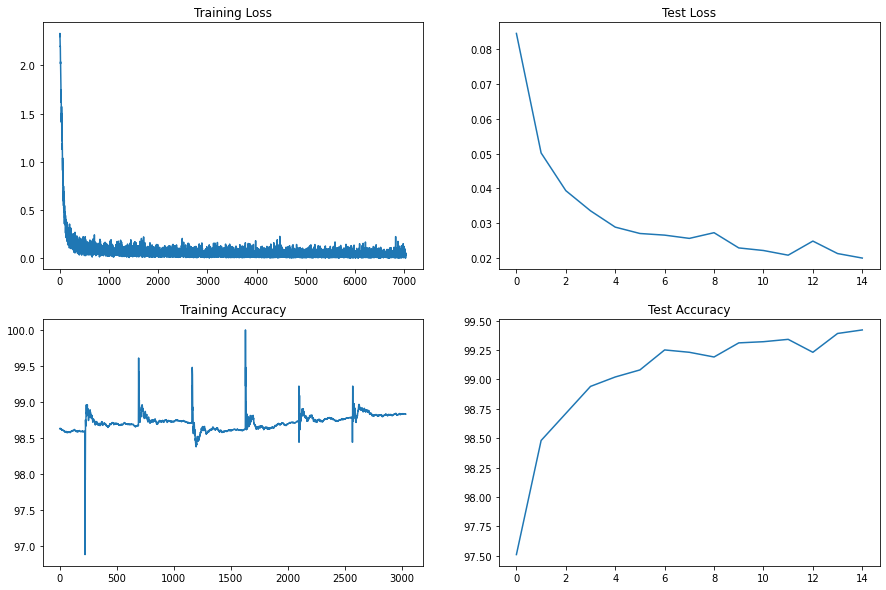

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")